# Exercício - Classificação de Jets
---

### Objetivos: 

* Modificar a rede neural apresentada para melhorar a acurácia do modelo;
* Comparar o modelo de rede neural com outro modelo do scikit learn de sua preferencia;
* Utilize os recursos aprendidos em aula: regularização, validação cruzada, busca por hyperparametros, preparação de dados, etc para validar os resultados e buscar o melhor modelo;
* Gere curvas de aprendizado do modelo para explicar o impacto das mudanças feitas no modelo.

 

### Entregar: 

* Descrição completa e documentada da exploração em jupyter;
* Apresentacao dos resultados usando slides (15 m);
    * Apresentar uma analise exploratória do problema;
    * Explique as acoes tomadas para definir o modelo;
    * Apresente a comparação entre os modelos;
    * Caracterize a acurácia em termos de falso positivo e falso negativo.

# Preparando o ambiente
---
As aulas foram ministradas utilizando tensorflow==2, mas este notebook utiliza um framework que exige tensorflow==1.14. Assim, a versão adequada foi instalada diretamente no ambiente conda e o comando de instalação do tensorflow a seguir foi ignorado.

In [282]:
# Atualizando tensorflow para versão 2.0.0
#!pip install tensorflow==2

Em seguida, foi instalado via pip o framework "talos", que auxiliará, posteriormente, na otimização dos hiperparâmetros.

In [3]:
!pip install talos

In [129]:
# Importanto bibliotecas
import pandas as pd
import numpy as np

# Tensorflow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend as K

# Visualização
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

# Modelos de Classificação
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Ferramentas
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import talos


Primeiramente, os dados foram lidos e tratados conforme consta no notebook fornecido em aula. Os passos foram simplificados por não serem o foco do exercício.

In [10]:
url_signal = 'https://raw.githubusercontent.com/raphaelmcobe/jet-classification/master/signal_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt'
url_bg = 'https://github.com/raphaelmcobe/jet-classification/raw/master/background_PU0_13TeV_MJ-65-95_PTJ-250-300_ext.txt'
signal_data = pd.read_table(url_signal, header=None)
background_data = pd.read_table(url_bg, header=None, dtype=np.float32)

# Dropando coluna extra
signal_data.drop(625, axis=1, inplace=True)
background_data.drop(625, axis=1, inplace=True)

# Adicionando coluna de 1's para identificar dados "signal"
signal_data[625] = 1
# Adicionando coluna de 0's para identificar dados "background"
background_data[625] = 0

# Concatenando dados em 1 só dataframe
frames = [signal_data, background_data]
full_data = pd.concat(frames)

# Mesclando dados (para não ficar sequencia de 0's e 1's)
full_data = full_data.sample(frac=1).reset_index(drop=True)

# Renomeando ultima coluna: 'class'
full_data.rename(columns={625:'class'}, inplace=True)

Uma vez lida a base e tratados os dados, é feita a visualização do dataframe apenas a título de verificação superficial.

In [11]:
# Visualizando como estão os dados
from IPython.core.display import display
with pd.option_context('display.max_rows', 200, 'display.max_columns', 15, 
                       'display.float_format', '{:.2f}'.format):
    display(full_data)

,0,1,2,3,4,5,6,...,619,620,621,622,623,624,class
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22591,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
22592,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
22593,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
22594,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0


Depois, separa-se os dados em X (625 pixels de cada imagem) e y (classificação em 0-background e 1-signal).

In [12]:
# Separando em X e y para os classificadores
X = full_data.drop(['class'], axis=1)
y = full_data['class']

# Abordagem utilizada
---

Para a escolha ótima dos hiperparâmetros foi utilizado o framework *talos*, que viabiliza a iteração exaustiva de um dicionário de parâmetros e poupa alguns passos manuais que torna o processo massante.

### Funcionamento do framework Talos

O framework possui uma arquitetura lógica de implementação bastante simples, que consiste em 3 passos básicos:
1. Definição de uma função que inicia o modelo da rede neural;
2. Declaração de um dicionário contendo os hiperparametros a serem analisados;
3. Execução do método "Scan", para avaliação dos hiperparametros do dicionário.

### Contextualização

Para facilitar o entendimento, observa-se como poderia ser desenvolvida uma rotina de criação de uma rede neural, com base no notebook fornecido em aula:

```
model = Sequential()
model.add(Dense(256, input_dim = x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='mse', optimizer='sgd', metrics='accuracy')

history = model.fit(x_train, y_train, 
                    validation_data=[x_test, y_test],
                    batch_size=128],
                    epochs=50,
                    verbose=0)
```
    
A função acima inicia uma rede neural com 2 camadas, utilizando o modelo Sequential(): a primeira camada com 256 neurônios e função de ativação 'relu'; e a segunda com 2 neurônios e função de ativação 'softmax'. Entre essas duas camadas, está um dropout de 20%. Depois, o modelo é compilado com uma função de custo do tipo *MSE*, otimizador do tipo *SGD* e medida de acurácia do tipo *accuracy*. Por fim, é realizado o treinamento, alocando-se o resultado numa variavel (*history*). 

Agora, se fosse necessário encapsular toda essa rotina numa função, isso poderia ser feito conforme o exemplo a seguir:

```
def MyNeuralNet(x_train,y_train,x_test,y_test):
    model = Sequential()
    model.add(Dense(256, input_dim = x_train.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='mse', optimizer='sgd', metrics='accuracy')

    history = model.fit(x_train, y_train, 
                        validation_data=[x_test, y_test],
                        batch_size=128],
                        epochs=50,
                    verbose=0)
    return history, model
```

### Passo 1:

Para utilizar o framework *Talos*, será necessária apenas referenciar os parâmetros da função acima que se deseja otimizar, ao invés de inserí-los diretamente na construção da rede neural. Segue adaptação:

In [284]:
def duan_neural_net(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
                    activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(2, activation=params['last_activation']))    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'],
                  metrics=['acc']) 
    
    history = model.fit(x_train, y_train, 
                        validation_data=[x_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[talos.utils.live()],
                        epochs=params['epochs'],
                        verbose=0)

    return history, model

Os parametros que se deseja otimizar foram generalizados de forma a encaixar no framework *talos*. Perceba que as alterações foram feitas no número de neurônios da primeira camada, nas funções de ativação de ambas as camadas, no dropout, no loss, no otimizador, na métrica de acurácia, no batch_size e no número de épocas (estes são os parametros que se deseja otimizar).

Um parametro extra foi adicionado no treinamento do modelo: callback. Este parametro serve para estipular algum tipo de função que seja executada durante cada treinamento. Neste caso, utilizou-se uma função do próprio framework *talos* que plota as atualizações da acurácia e do erro utilizado. Isso ajuda a visualizar a curva de aprendizado do modelo.

### Passo 2:

Em seguida, precisa-se definir um dicionário que contenha os valores dos hiperparametros que se deseja testar a fim de buscar um resultado ótimo.

In [285]:
p = {'first_neuron':[64,128,256,512],
     'hidden_layers':[0],
     'batch_size': [1000],
     'epochs': [200],
     'dropout': [0, 0.1, 0.2],
     'optimizer': ['rmsprop'],
     'losses': ['msle'],
     'activation':['relu','softmax'],
     'last_activation': ['softmax']}

# OUTRAS OPÇÕES:
# 'optimizer': ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam'],
# 'activation':['relu', 'softmax', 'sigmoid']}
# 'losses': ['mse','mae','msle']

No dicionário acima, devem ser listados todos os parâmetros que se deseja testar. Os valores são escolhidos discricionariamente e podem ser alterados conforme constatação dos resultados.

**ANTES DO PASSO 3:** conforme visto no exemplo fornecido em aula, deseja-se observar a saída como uma distribuição de probabilidades, onde ao invés de se ter uma coluna de 0's e 1's, tenha-se uma coluna com a distribuição de probabilidade, de forma que o resultado 1 seja apresentado como [0,1] e o resultado 0 seja apresentado como [1,0].

In [288]:
y_cat = to_categorical(y.values, num_classes=2)

### Passo 3:

Agora basta executar o método *Scan()* para dar início a validação dos hiperparametros. Para isso, é importante normalizar as observações (variável X).

In [289]:
# normalizando X
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Agora, de forma prática, é inserido os parametros do método *Scan()* para início da validação:

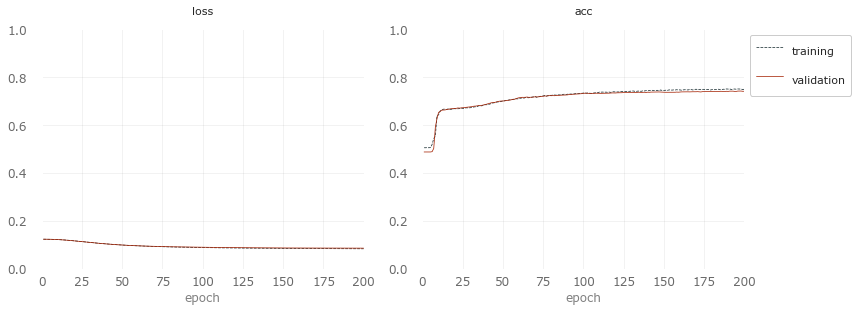
















100%|███████████████████████████████████████████████████████████████████████████████| 24/24 [1:04:33<00:00, 161.41s/it]


In [279]:
t = talos.Scan(x=X_scaled, y=y_cat, params=p, model=duan_neural_net, experiment_name='duan_neural_net',print_params=True)

**OBS: o plot acima é referente apenas à última rodada do experimento. Não se trata de uma representação geral. O gráfico é plotado a cada rodada, excluindo o gráfico da rodada anterior.**

Como visto acima, o método *Scan()* dividir os dados X e y em dados de treino e teste (visto com detalhes na documentação do framework) e irá aplicar a função que declaramos anteriormente (chamada duan_neural_net).

O parametro "experiment_name" serve para dar nome a uma pasta que será criada com todas as informações deste teste. Já o parametro "print_params" fornece a opção de mostrar os parametros utilizados após cada *round* (combinação de parametros utilizadas naquela execução).

Adicionalmente, percebe-se que os gráficos atualizam em tempo real à medida que as épocas vão evoluindo. Neles, pode-se observar a curva de aprendizado de duas formas: diminuição do output da função de custo (esquerda) e aumento da acurácia (direita). Em ambos a linha contínua vermelha representa a desenvoltura do modelo nos dados de teste e a linha pontilhada preta representa a desenvoltura nos dados de treino.

Agora os resultados estão disponíveis para acesso em diferentes formas.

### Observando resultados

Dentre as diversas possíbilidades de análise dos outputs, primeiramente vamos observar o dataframe gerado com o resultado de cada round:

In [290]:
t.data

,round_epochs,loss,acc,val_loss,val_acc,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,last_activation,losses,optimizer
0,200,0.054109,0.854650,0.084492,0.754979,relu,1000,0.0,200,64,0,softmax,msle,rmsprop
1,200,0.047536,0.878928,0.085634,0.752618,relu,1000,0.0,200,128,0,softmax,msle,rmsprop
2,200,0.040078,0.902952,0.086987,0.752323,relu,1000,0.0,200,256,0,softmax,msle,rmsprop
3,200,0.035457,0.916735,0.089150,0.754684,relu,1000,0.0,200,512,0,softmax,msle,rmsprop
4,200,0.056271,0.848391,0.083541,0.763092,relu,1000,0.1,200,64,0,softmax,msle,rmsprop
5,200,0.049991,0.870329,0.083441,0.764420,relu,1000,0.1,200,128,0,softmax,msle,rmsprop
6,200,0.043079,0.891699,0.085945,0.758076,relu,1000,0.1,200,256,0,softmax,msle,rmsprop
7,200,0.036809,0.911677,0.088898,0.755274,relu,1000,0.1,200,512,0,softmax,msle,rmsprop
8,200,0.058680,0.838465,0.081993,0.765747,relu,1000,0.2,200,64,0,softmax,msle,rmsprop
9,200,0.050776,0.866662,0.083484,0.764420,relu,1000,0.2,200,128,0,softmax,msle,rmsprop


Acima, o dataframe descreve todas as informações relativas aos parâmetros, funções de custo e acurácia de cada round. Para acessar a melhor parametrização, pasta utilizar o pandas para fazer o filtro desejado. 

De forma exemplificativa, a seguir é filtrado o round que possui maior valor de acurácia nos dados de teste:

In [292]:
accMax = t.data['val_acc'].max()
t.data[t.data['val_acc']==accMax]

,round_epochs,loss,acc,val_loss,val_acc,activation,batch_size,dropout,epochs,first_neuron,hidden_layers,last_activation,losses,optimizer
8,200,0.05868,0.838465,0.081993,0.765747,relu,1000,0.2,200,64,0,softmax,msle,rmsprop


Interpretando o dataframe acima, o melhor resultado foi utilizando a primeira camada com 64 neurônios, 0 hidden_layers e função de ativação 'relu', além de uma segunda camada com 2 neurônios (default) e função de ativação 'softmax'. Este foi o 8º round e nele foi utilizado o otimizador 'rmsprop'.

### Informações adicionais

O framework também conta com algumas ferramentas extras, como:

**1. Detalhes do experimento realizado:**

In [293]:
t.details

experiment_name         duan_neural_net
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            02/20/20/21:38
x_shape                    (22596, 625)
y_shape                      (22596, 2)
dtype: object

**2. Acesso a valores de entropia das épocas em cada round:**

In [294]:
t.learning_entropy

,loss,acc
0,0.008993,0.000704
1,0.015857,0.001061
2,0.028011,0.001426
3,0.038590,0.001595
4,0.007040,0.000504
5,0.012608,0.000763
6,0.021831,0.001123
7,0.035035,0.001416
8,0.004936,0.000408
9,0.011501,0.000748


**3. Parametros utilizados e pesos salvos em cada round:** exemplo do round 0 a seguir. 

In [302]:
print(t.saved_models[0])
print("---")
print(t.saved_weights[0])

{"class_name": "Sequential", "config": {"name": "sequential_1", "layers": [{"class_name": "Dense", "config": {"name": "dense_1", "trainable": true, "batch_input_shape": [null, 625], "dtype": "float32", "units": 64, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Zeros", "config": {"dtype": "float32"}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dropout", "config": {"name": "dropout", "trainable": true, "dtype": "float32", "rate": 0, "noise_shape": null, "seed": null}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": true, "dtype": "float32", "units": 2, "activation": "softmax", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null, "dtype": "float32"}}, "bias_initializer": {"class_name": "Z

**4. Correlação entre hiperparametros e uma dada métrica:**

In [307]:
analise = talos.Analyze(t)
analise.correlate('val_loss', ['acc', 'loss', 'val_loss'])

round_epochs          NaN
val_acc         -0.427243
batch_size            NaN
dropout         -0.048639
epochs                NaN
first_neuron     0.658016
hidden_layers         NaN
Name: val_loss, dtype: float64

**5. Representações gráficas:**

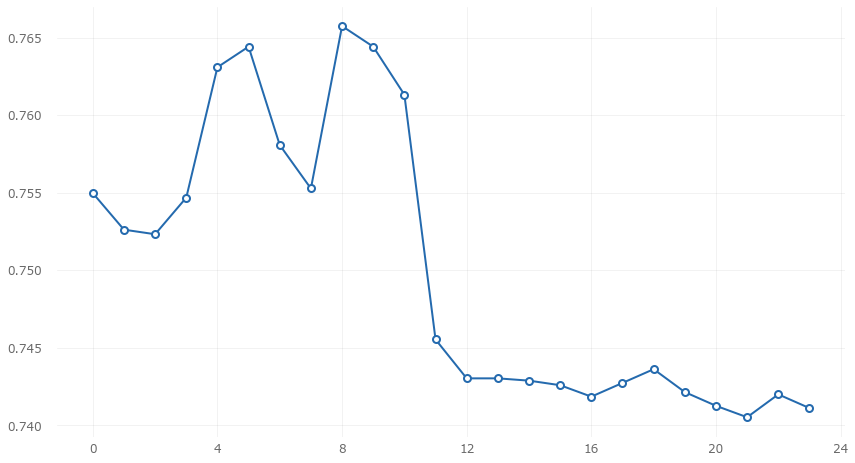

In [309]:
# Linha
analyze_object.plot_line('val_acc')

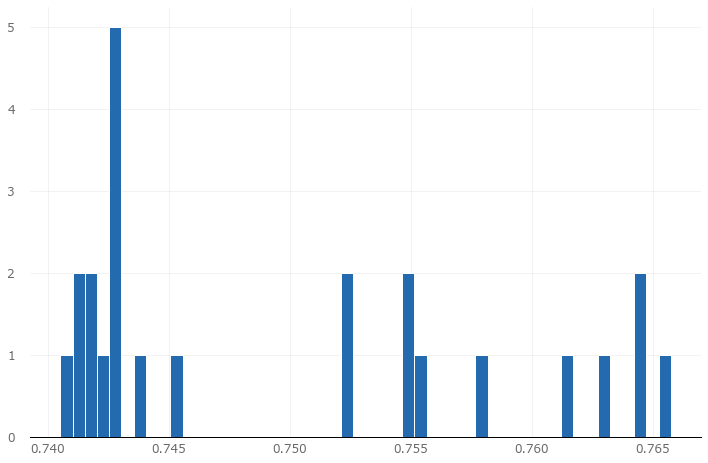

In [311]:
# Histograma
analyze_object.plot_hist('val_acc', bins=50)

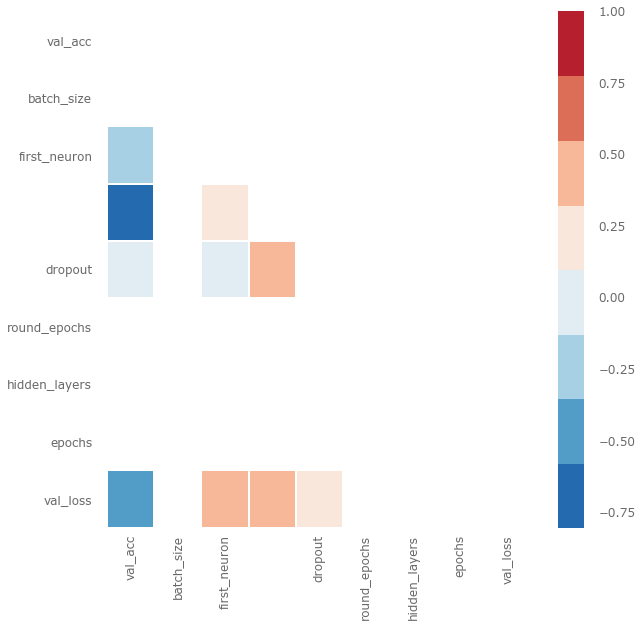

In [312]:
# Mapa de calor (correlação)
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

**Além das funcionalidades expostas, há também a possibilidade de fazer *deploy* do modelo, uma vez alcançado desempenho satisfatório. Entretanto, essa funcionalidade não foi explorada aqui, por não fazer parte do objetivo do exercício, o que não impede de ser realizada no futuro.**

# Aplicando PCA
---
A seguir foi analizada a performance de alguns modelos de classificação utilizando técnicas aprendidas em aulas anteriores (validação cruzada, PCA e pipeline).

Primeiramente, reduziu-se os dados para 2 dimensões a fim de visualizar graficamente o comportamento dos dados.

### Reduzindo os dados para 2D para visualização

In [21]:
# Configurando PCA(2) e printando shape antes e depois
pca = PCA(2)  # projecao de 625 para 2 dimensoes (colunas)
projected = pca.fit_transform(X)
print("Shape antes: ",X.shape)
print("Shape depois:",projected.shape)

Shape antes:  (22596, 625)
Shape depois: (22596, 2)


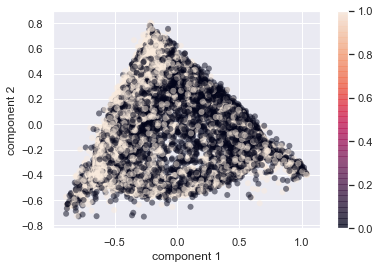

In [22]:
# Plotando dados reduzidos em 2D
plt.scatter(projected[:, 0], projected[:, 1],
            c=y.values.ravel(), edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

### Plotando curva para identificação da quantidade ótima de atributos

Aqui o PCA é utilizado para gerar a curva que mostra a estabilidade da variancia, conforme mais atributos são levados em consideração.

Text(0, 0.5, 'cumulative explained variance')

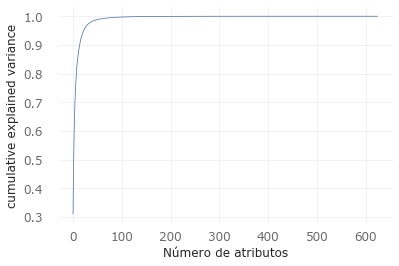

In [316]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de atributos')
plt.ylabel('cumulative explained variance')

**O gráfico acima mostra que a partir de aproximadamente 80~90 atributos a variancia estabiliza. Isso significa que daí em diante, a adição de colunas não influencia no resultado. Sabendo disso, pode-se trabalhar com menos atributos para poupar processamento.**

Será avaliada, portanto, a seguinte lista de quantidade de atributos: ```[80,85,90,95,100]```.

Apesar da lista acima, a título de curiosidade, plotou-se também a mesma curva, mas com os dados normalizados:

Text(0, 0.5, 'cumulative explained variance (scaled)')

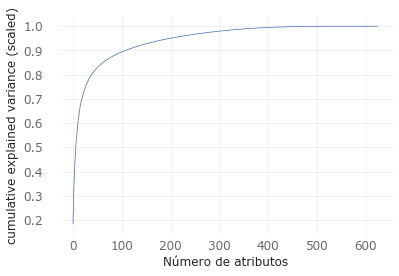

In [317]:
pca = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de atributos')
plt.ylabel('cumulative explained variance (scaled)')

Dessa vez, a quantidade de atributos relevantes sobe para 400. 

# Pipeline + PCA + GridSearchCV em 6 classificadores diferentes
---

Abaixo foram utilizados Pipeline, PCA e GridSearchCV combinados para aplicar seis modelos diferentes na base estudada, a fim de encontrar algum resultado satisfatório.

In [24]:
# Instanciando pipelines
pipe_lr    = Pipeline([('scl', StandardScaler()), ('pca', PCA()), ('clfLogreg', LogisticRegression(solver='lbfgs'))])
pipe_knn   = Pipeline([('scl', StandardScaler()), ('pca', PCA()), ('clfKnn', KNeighborsClassifier())])
pipe_dt    = Pipeline([('scl', StandardScaler()), ('pca', PCA()), ('clfTree', DecisionTreeClassifier())])
pipe_nb    = Pipeline([('scl', StandardScaler()), ('pca', PCA()), ('clfNb', GaussianNB())])
pipe_ridge = Pipeline([('scl', StandardScaler()), ('pca', PCA()), ('clfRidge', RidgeClassifier())])
pipe_sgd   = Pipeline([('scl', StandardScaler()), ('pca', PCA()), ('clfSgd', SGDClassifier())])

# Lista de pipelines
pipelines = [pipe_lr, pipe_knn, pipe_dt, pipe_nb, pipe_ridge, pipe_sgd]

# quantidades de atributos a serem testadas
grid_params = [{'pca__n_components': [80, 85, 90, 95, 100]}]

# dicionário de pipelines
pipe_dict = {0: 'Logistic Regression', 1: 'KNN', 2: 'Decision Tree', 3: 'Naive Bayes', 4: 'Ridge', 5: 'SGD'}

# Usando gridsearch para fazer busca exaustiva de uma parametrização ótima
for i, pipe in enumerate(pipelines):
    
    # Instanciando GridSearch para cada pipe 
    gs = GridSearchCV(estimator = pipe, param_grid = grid_params, scoring = 'accuracy')
    
    # Treinando modelo do pipe atual
    gs.fit(X_train, y_train.values.ravel())
    
    # Printando melhor acurácia
    print('%s pipeline com PCA\n---' % pipe_dict[i])
    print('Best accuracy: %.3f' % gs.best_score_)

    # Printando quantidade ótima de atributos em cada modelo
    print('Best params:', gs.best_params_)
    print("\n---")

C:\Users\duanc\Miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\duanc\Miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-r

Logistic Regression pipeline com PCA
---
Best accuracy: 0.730
Best params: {'pca__n_components': 85}

---
KNN pipeline com PCA
---
Best accuracy: 0.714
Best params: {'pca__n_components': 80}

---
Decision Tree pipeline com PCA
---
Best accuracy: 0.664
Best params: {'pca__n_components': 85}

---
Naive Bayes pipeline com PCA
---
Best accuracy: 0.574
Best params: {'pca__n_components': 95}

---
Ridge pipeline com PCA
---
Best accuracy: 0.722
Best params: {'pca__n_components': 90}

---
SGD pipeline com PCA
---
Best accuracy: 0.706
Best params: {'pca__n_components': 100}

---


### Conclusão

Alguns modelos apresentaram acurácia até maior que a rede neural simples implementada no notebook fornecido. Entretando, não superam o resultado encontrado com a rede neural vista anteriormente.

As comparações de performance computacional (tempo) foram observadas em notebooks diferentes, apenas a título de conhecimento, mas não foram registradas neste notebook.

Por limitação de tempo, a matriz confusão solicitada também não foi computada neste notebook.